# 最小二乘估计与相关方法

## 模型

$$
A(q^{-1})y(k)=B(q^{-1})u(k-d)+e(k) 
$$

其中 $q^{-1}$为时移算子。$A(x)$为$x$的多项式。展开可写作

$$
y(k) = -a_1 y (k-1)-a_2 y (k-2)- \dots -a_{n_a} y(k-n_a) + b_0 u(k-d) +b_1 u (k-d-1)+ \dots +b_{n_b} u(k-d-n_b)+e(k)
$$

其中$n_a,n_b$为阶数，$d$（delay）为迟滞期数。

则上式可以紧凑的写成

$$
y(k)=x^T(k) \theta + e(k)
$$


## 最小二乘法(OLS)

由导数或正则方程，

$$
\hat{\theta} = (X^TX)^{-1} X^TY
$$



In [1]:
import numpy as np
from numpy.linalg import inv

In [2]:
t = np.array([1, 2, 3, 4, 5, 6],dtype=float)
l = np.array([8.94, 20.05, 50.65, 72.19, 129.85, 171.56])

# l = 1/2gt^2

In [3]:
X = np.expand_dims(t**2, axis=1)
Y = l * 2

inv(X.T @ X) @ X.T @ Y

array([9.77796923])

In [4]:
dat = np.loadtxt('coldwar_data.txt', skiprows=True)

In [5]:
iran_iraq = dat[:8,1:3]
nato_warsaw = dat[:10,3:]

In [6]:
iran_iraq

array([[ 2891.,   909.],
       [ 3982.,  1123.],
       [ 8801.,  2210.],
       [11230.,  2247.],
       [12178.,  2204.],
       [ 9867.,  2303.],
       [ 9165.,  2179.],
       [ 5080.,  2675.]])

In [7]:
nato_warsaw

array([[216478., 112893.],
       [211146., 115020.],
       [212267., 117169.],
       [210525., 119612.],
       [205717., 121461.],
       [212009., 123561.],
       [215988., 125498.],
       [218561., 127185.],
       [225411., 129000.],
       [233957., 131595.]])

In [8]:
X = np.c_[iran_iraq[:-1], np.ones(iran_iraq.shape[0]-1)]
Y = iran_iraq[1:,0]
inv(X.T @ X) @ X.T @ Y

array([ 5.48069202e-01, -2.03436959e-01,  4.44754119e+03])

In [9]:
X = np.c_[iran_iraq[:-1], np.ones(iran_iraq.shape[0]-1)]
Y = iran_iraq[1:,1]
inv(X.T @ X) @ X.T @ Y

array([-3.05530837e-02,  7.44323824e-01,  9.87156504e+02])

两伊模型第一个结果ppt上写错了吧。。

In [10]:
X = np.c_[nato_warsaw[:-1], np.ones(nato_warsaw.shape[0]-1)]
Y = nato_warsaw[1:,0]
inv(X.T @ X) @ X.T @ Y

array([ 8.94028953e-01,  7.86815620e-01, -7.07697548e+04])

In [11]:
X = np.c_[nato_warsaw[:-1], np.ones(nato_warsaw.shape[0]-1)]
Y = nato_warsaw[1:,1]
inv(X.T @ X) @ X.T @ Y

array([ 2.55962375e-02,  9.80690954e-01, -1.06403149e+03])

## 加权最小二乘（WLS）

设残差平方和为为$J = \epsilon^T \epsilon$，我们可以把目标改为它与一个$W$相关的二次型（核）的最小化：

$$
J_W = \epsilon^T W \epsilon
$$

则对应的加权最小二乘估计量为：

$$
\hat{\theta}_{\text{LSW}} = (X^T W X)^{-1} X^T W Y
$$

显然$W = I$时在，与OLS结果一致。

## 递推最小二乘 RLS

递推最小二乘利用分块矩阵推导，可以避免显示矩阵求导增量更新，也可以用于参数在线估计。

$$
\begin{align*}
\hat{\theta}(N+1) &= \hat{\theta}(N) + K(N+1)(y(N+1)-x^T(N+1) \hat{\theta}(N)) \\
P(N+1) &= (I - K(N+1) x^T(N+1)) P(N) \\
K(N+1) &= \frac{P(N)x(N+1)}{1+x^T(N+1)P(N)x(N+1)}
\end{align*}
$$

其中$\hat{\theta}(N)$正是$N$轮迭代时参数估计值。$P(N) = (X_N^T X_N)^{-1}$ ，注意估计量协方差矩阵为$\sigma^2 (X^TX)^{-1}$。
$K$称为修正权系数，它不是一个状态，而是根据“当前”$P,K$与误差情况决定步长。

算法的初值可以来自某次OLS估计结果然后用于增量更新：

\begin{align*}
\hat{\theta}(N) &= (X_N^T X_N)^{-1} X_N^T Y_N \\
P(N) &= (X_N^T X_N)^{-1}
\end{align*}

也可以用相对任意的初始值：

$$
\begin{align*}
\hat{\theta}(0) &= \mathbf{0} \\
P(0) &= \alpha \mathbf{I}
\end{align*}
$$

$\alpha$是足够大的常数。

In [31]:
def rls_step(x, y, theta, P, rho=1.0):
    # K -> theta -> P
    # x: m
    # y: 1
    # theta: m
    # P m*m
    m = x.shape[0]
    K = (P @ x)/(rho + x @ P @ x)
    
    theta = theta + K * (y - x @ theta)
    I = np.eye(m)
    P = 1/rho * (P - np.outer(K, x @ P))
    return theta, P

In [33]:
def rls(X, Y, theta = None, K=None, P=None, alpha=1., rho=1.0, trace = False):
    n,m = X.shape
    if theta is None:
        theta = np.zeros(m)
    if P is None:
        P = alpha * np.eye(m)
    
    if trace:
        theta_list = [theta.copy()]
        P_list = [P.copy()]
    
    for i in range(n):
        theta, P = rls_step(X[i], Y[i], theta, P, rho = rho)
        if trace:
            theta_list.append(theta.copy())
            P_list.append(P.copy())
    if trace:
        return theta_list, P_list
    return theta, P

In [14]:
rls(X,Y)

(array([ 0.02092845,  0.98021667, -5.86883003]),
 array([[ 1.75693337e-09, -3.06366216e-09, -4.38689152e-06],
        [-3.06366217e-09,  5.41645213e-09, -4.45729926e-07],
        [-4.38689194e-06, -4.45729206e-07,  9.94484349e-01]]))

## 渐消记忆RLS算法

相当于以$W_N = diag(\rho^{N-1},\rho^{N-2},\dots,1)$的加权最小二乘法。$\rho \in [ 0.95,0.999]$

$$
\begin{align*}
\hat{\theta}(N+1) &=  \hat{\theta}(N) + K(N+1)(y(N+1)-x^T(N+1) \hat{\theta}(N)) \\
P(N+1) &= \frac{1}{\rho} (I - K(N+1) x^T(N+1)) P(N) \\
K(N+1) &=  \frac{P(N)x(N+1)}{\rho+x^T(N+1)P(N)x(N+1)}
\end{align*}
$$

可用于追踪慢时变参数，但看起来就和什么指数平滑法一样扯淡。

In [27]:
u = np.tile(np.repeat([1., -1.],100),15) # 3000
xi = np.random.randn(3000) * np.sqrt(0.1)
y = np.empty(3000)
y[0] = y[1] = 0.0

a1 = 0.6
a2 = -0.7
b1 = 1.0
b2 = 0.5

for k in range(2,1000):
    y[k] = a1 * y[k-1] + a2 * y[k-2] + b1 * u[k-1] + b2 * u[k-2] + xi[k]

a1 = 1.2
    
for k in range(1000,3000):
    y[k] = a1 * y[k-1] + a2 * y[k-2] + b1 * u[k-1] + b2 * u[k-2] + xi[k]
    


In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

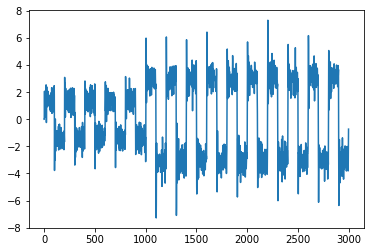

In [30]:
plt.plot(y)

In [35]:
X = np.c_[y[1:-1],y[:-2],u[1:-1],u[:-2]]
Y = y[2:]
theta_list, P_list = rls(X, Y, rho=0.99 ,trace=True)

$\xi$

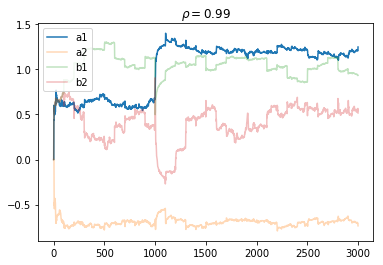

In [42]:
theta_array = np.array(theta_list)

plt.plot(theta_array[:,0],label='a1')
plt.plot(theta_array[:,1],label='a2',alpha=0.3)
plt.plot(theta_array[:,2],label='b1',alpha=0.3)
plt.plot(theta_array[:,3],label='b2',alpha=0.3)
plt.legend()
plt.title(r'$\rho=0.99$')
plt.show()

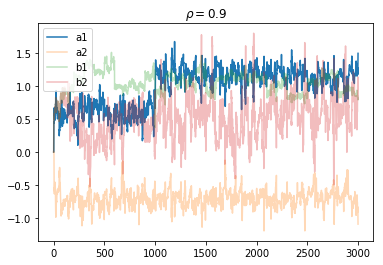

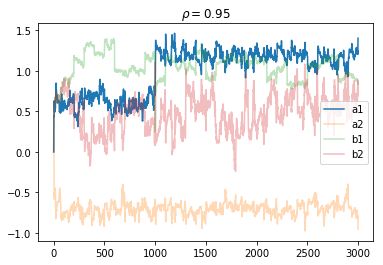

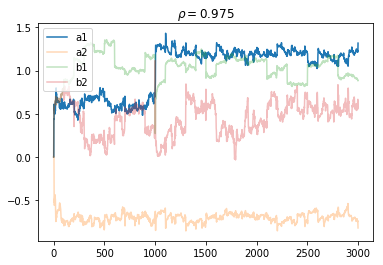

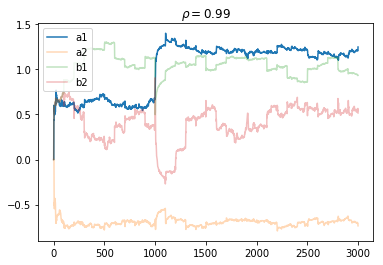

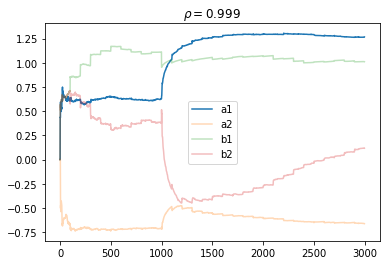

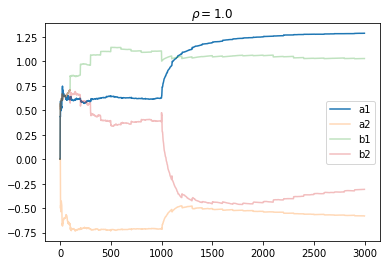

In [47]:
for rho in [0.9, 0.95,0.975,0.99,0.999,1.0]:
    theta_list, P_list = rls(X, Y, rho=rho ,trace=True)
    theta_array = np.array(theta_list)

    plt.plot(theta_array[:,0],label='a1')
    plt.plot(theta_array[:,1],label='a2',alpha=0.3)
    plt.plot(theta_array[:,2],label='b1',alpha=0.3)
    plt.plot(theta_array[:,3],label='b2',alpha=0.3)
    plt.legend()
    plt.title(r'$\rho='+str(rho)+'$')
    plt.show()

In [86]:
a = np.empty(1000)
b = np.empty(1000)
a[:300] = 0.8
a[300:] = 0.6
b[:300] = 0.5
b[300:] = 0.3

#u = np.random.randn(1000)
u = np.tile(np.repeat([1., -1.],10),50) # 1000
xi = np.random.randn(1000) * 0.1
y = np.empty(1000)
y[0] = 0.0

for k in range(1,1000):
    y[k] = -a[k] * y[k-1] + b[k] * u[k-1] + xi[k] 

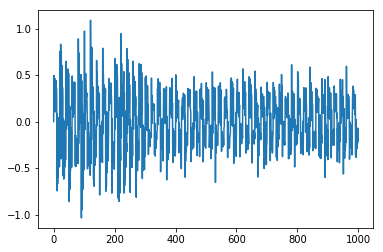

In [87]:
plt.plot(y)

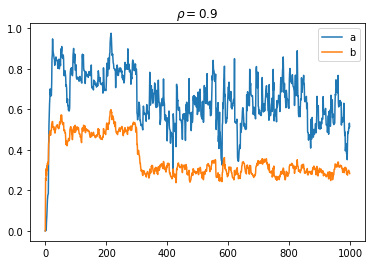

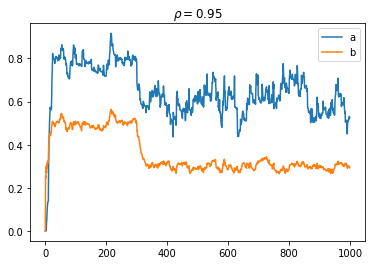

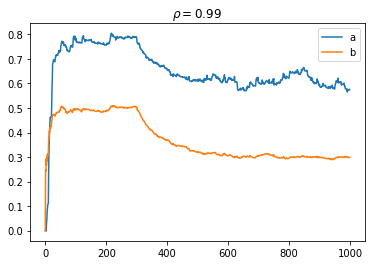

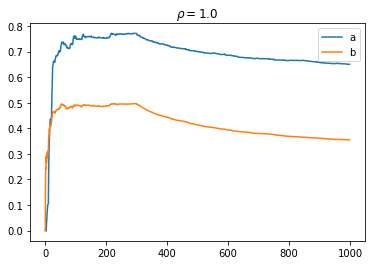

In [88]:
X = np.c_[y[:-1],u[:-1]]
Y = y[1:]

for rho in [0.9, 0.95, 0.99, 1.0]:
    theta_list, P_list = rls(X, Y, rho=rho ,trace=True)
    theta_array = np.array(theta_list)

    plt.plot(-theta_array[:,0],label='a')
    plt.plot(theta_array[:,1],label='b')
    plt.legend()
    plt.title(r'$\rho='+str(rho)+'$')
    plt.show()

In [89]:
u = np.random.randn(1000)
#u = np.tile(np.repeat([1., -1.],20),50) # 1000
xi = np.random.randn(1000) * 0.1
y = np.empty(1000)
y[0] = 0.0

for k in range(1,1000):
    y[k] = -a[k] * y[k-1] + b[k] * u[k-1] + xi[k] 

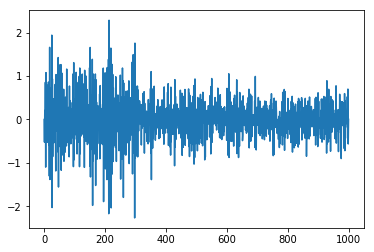

In [90]:
plt.plot(y)

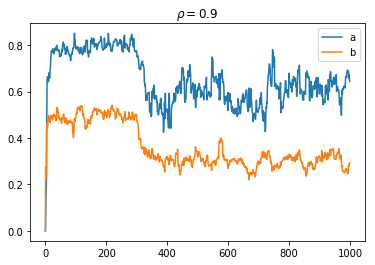

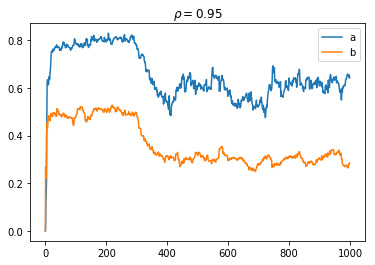

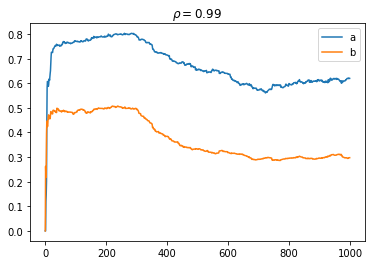

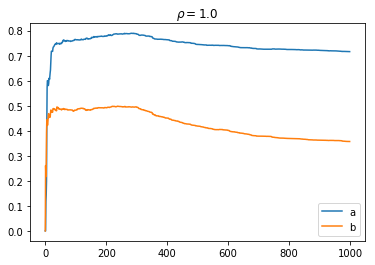

In [91]:
X = np.c_[y[:-1],u[:-1]]
Y = y[1:]

for rho in [0.9, 0.95, 0.99, 1.0]:
    theta_list, P_list = rls(X, Y, rho=rho ,trace=True)
    theta_array = np.array(theta_list)

    plt.plot(-theta_array[:,0],label='a')
    plt.plot(theta_array[:,1],label='b')
    plt.legend()
    plt.title(r'$\rho='+str(rho)+'$')
    plt.show()